<a href="https://colab.research.google.com/github/NeelGaji/CS-GY-6923-Machine-Learning/blob/main/lab2_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Acknowledgement

This lab is imported from prof. Christopher Musco's 2024 iteration of CS-GY 6923. Thanks Chris!

# Lab:  Model Order Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain.  In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces (see. e.g. https://www.youtube.com/watch?v=QRt8QCx3BCo).  In this lab, you will use model selection for performing some simple analysis on real neural signals.  

Before doing this lab, you should review the ideas in the polynomial model selection demo.  In addition to the concepts in that demo, you will learn to:
* Represent neural time-series data in arrays
* Load data from a pickle file
* Describe and fit memoryless linear models
* Describe and fit linear time-series models with delays
* Fit linear models with multiple target outputs
* Select the optimal delay via cross-validation

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="https://pubmed.ncbi.nlm.nih.gov/21613593/">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex. Being able to make such predictions is the precursor to [technologies like Braingate and Neuralink](https://www.youtube.com/watch?v=QRt8QCx3BCo) that use electrode implants to read neural activity that then controls a cursor or robotic arm.

We first load the key packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of datasets and can be used for projects as well.  However, the raw data files can be quite large.  To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data.  You can download the file `example_data_s1.pickle` from [this link](https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true).  Alternatively, you can directly run the following code.

In [4]:
fn_src = 'https://github.com/cpmusco/machinelearning2022/blob/master/data/example_data_s1.pickle?raw=true'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


The file is a *pickle* data structure, which is a package to serialize python objects into data files.  Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [5]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.
The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction

Our goal will be to predict **only** `y[i,0]` from `X`. We could just as easily predict movement in both directions, but this simplifies the lab.  So we reassign:

In [6]:
y = y[:,0]

Each time bin represent `tsamp=0.05` seconds of time.  Using `X.shape` and `y.shape` compute and print:
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `ttotal = ` total time of the experiment is seconds.

In [7]:
tsamp = 0.05  # sampling time in seconds

# TODO
nt = X.shape[0]
nneuron = X.shape[1]
ttotal = nt * tsamp

print(f"nt: {nt}, nneuron: {nneuron}, ttotal: {ttotal}")

nt: 61339, nneuron: 52, ttotal: 3066.9500000000003


## Fitting a Memoryless Linear Model

Let's first try a simple linear regression model to fit the data.

Before doing so, we want to split the data into a training and test set. We will use a 2/3 - 1/3 split, so 1/3 of the data should be used for testing.

Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set. Recall that `ytr` and `yts` should be taken from the *first column of `y` only*. You can use any utility to perform the split that you want, but make sure that it is *random*. I.e. don't just take the first rows of the data to be the training data. `np.random.permutation` might come in handy.

In [9]:
# TODO
# Xtr, Xts, ytr, yts = ...
np.random.seed(42)

perm = np.random.permutation(nt)

n_tr = int(nt * (2/3))

I_tr = perm[:n_tr]
I_ts = perm[n_tr:]
Xtr = X[I_tr, :]
ytr = y[I_tr]
Xts = X[I_ts, :]
yts = y[I_ts]

Next, write an function that, fits a linear model given a predictor matrix X and a vector of target values y. Your function should find the optimal beta to minimize the squared loss. You should do so using the matrix equations discussed in class -- do not use any built in functions from e.g. Scikit Learn.

 Your linear model should have an intercept (a column of all oness). Hint: You might want to use numpy's concatenate function and the ones function.

In [11]:
def fit_mult_linear(X,y):
    """
    Given matrix of predictors X and target vector y fit for a multiple linear regression model under the squared loss.
    """
    # TODO complete the following code
    n, p = X.shape
    ones_col = np.ones((n, 1))
    X1 = np.hstack((ones_col, X))

    beta = np.linalg.solve(X1.T @ X1, X1.T @ y)

    return beta

Now, use your function to fit a multiple linear regression model under squared loss using `Xtr,ytr`.
Make predictions  `yhat` using `Xts`.

In [13]:
# TODO
beta = fit_mult_linear(Xtr, ytr)
n_ts = Xts.shape[0]
Xts_1 = np.hstack((np.ones((n_ts, 1)), Xts))
yhat = Xts_1 @ beta

Compare `yhat` to `yts` to measure the **averaged squared loss** (empirical risk) on the test set. Print the output. You should obtain an average loss of around 32 or 33 if you are normalizing by 1/(test set size).

In [14]:
# TODO
loss = np.mean((yts - yhat)**2)
print(f"Average Squared Loss: {loss}")

Average Squared Loss: 33.090007227227794


It is useful to plot the predicted vs. true values. Plot `yhat` vs. `yts` with a scatter plot and label the axes. If the predicted values exactly matched the targets, we would expect to see a line with slope 1.

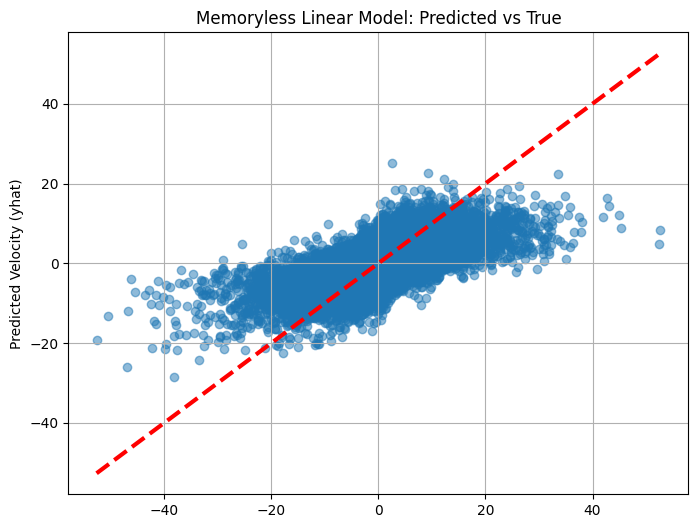

In [16]:
# TODO
plt.figure(figsize=(8,6))
plt.scatter(yts, yhat, alpha=0.5)
plt.plot([yts.min(), yts.max()], [yts.min(), yts.max()], 'r--', lw=3)
plt.ylabel("Predicted Velocity (yhat)")
plt.title("Memoryless Linear Model: Predicted vs True")
plt.grid(True)
plt.show()

## Fitting Models with Delay

One way we can improve the model accuracy is to used delayed version of the features.  Specifically, the model we used above mapped the features

$$
\hat{y}_i = \sum_{j=1}^{p} X_{i,j}*\beta_j + \beta_0
$$
where $p$ is the number of features and $\beta$ is our vector of coefficients.  In this model,  $\hat{y}_i$ at time $i$ was only dependent on the inputs  $X_{i,1,\ldots,p}$ at time $i$.  In signal processing, this is called a *memoryless* model.  However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs $X_{i,1,\ldots,p}$ and the outputs $y_i$.  For such cases, we can use a model of the form,

$$
\hat{y}_{i+d} = \sum_{m=0}^d \sum_{j=1}^{p} X_{i+m,j}*\beta_{j,m} + \beta_{0,m}
$$
    
where $\beta$ is now a 2-dim array of coefficients where $\beta_{j,m}$ is the influence of the input $X_{i+m,j}$ onto output $y_{i+d}$


In signal processing, this model is called an *FIR* filter.  The point is that the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.  Hence, it depends on the last `d+1` time steps, not just the most recent time.

To translate this into a linear regression problem, complete the following function that creates a new feature and target matrix where:

    Xdly[i,:] is the concatenation of the vectors X[i,:], X[i+1,:], ..., X[i+d,:]
    ydly[i,:] = y[i+d,:]
    
Note that if `X` is `n x p` then `Xdly` will be `n-d x (d+1)*p`.  


In [17]:
def create_dly_data(X,y,d):
    """
    Create delayed data
    """
    # TODO
    n, p = X.shape
    n_dly = n - d

    Xdly = np.zeros((n_dly, (d+1)*p))
    for i in range(d + 1):
        Xdly[:, i*p : (i+1)*p] = X[i : n_dly + i, :]

    ydly = y[d:]

    return Xdly, ydly

Now fit an linear delayed model with `d=6` additional delay lags.  That is,
* Create delayed data `Xdly,ydly=create_dly_data(X,y,6)`
* Split the data into training and test as before
* Fit the model on the training data
* Measure the average squared loss (risk) on the test data

You should see a significant improvement from the memoryless model.

In [18]:
# TODO
d = 6

Xdly, ydly = create_dly_data(X, y, d)

nt_dly = Xdly.shape[0]
perm_dly = np.random.permutation(nt_dly)
n_tr_dly = int(nt_dly * (2/3))

I_tr_dly = perm_dly[:n_tr_dly]
I_ts_dly = perm_dly[n_tr_dly:]

Xtr_dly = Xdly[I_tr_dly, :]
ytr_dly = ydly[I_tr_dly]
Xts_dly = Xdly[I_ts_dly, :]
yts_dly = ydly[I_ts_dly]

beta_dly = fit_mult_linear(Xtr_dly, ytr_dly)


Xts_dly_1 = np.hstack((np.ones((Xts_dly.shape[0], 1)), Xts_dly))
yhat_dly = Xts_dly_1 @ beta_dly


loss_dly = np.mean((yts_dly - yhat_dly)**2)
print(f"Average Squared Loss (d=6): {loss_dly}")

Average Squared Loss (d=6): 17.813215678278993


Plot the predicted vs. true values as before. You should visually see the improvement too.

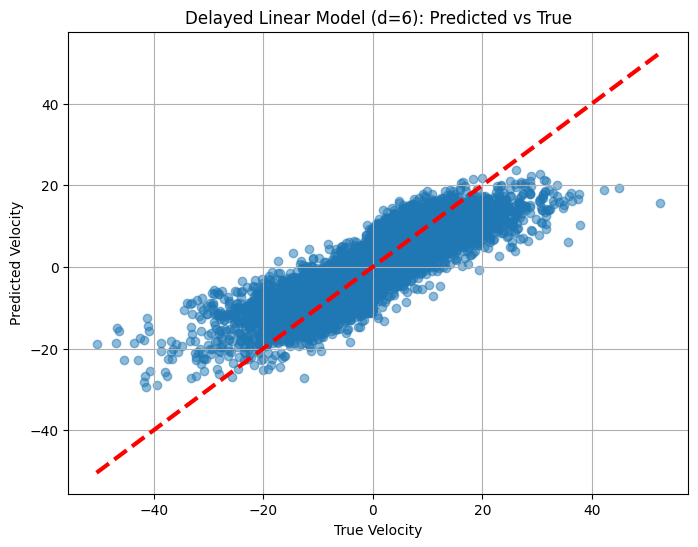

In [19]:
# TODO
plt.figure(figsize=(8,6))
plt.scatter(yts_dly, yhat_dly, alpha=0.5)
plt.plot([yts_dly.min(), yts_dly.max()], [yts_dly.min(), yts_dly.max()], 'r--', lw=3)
plt.xlabel("True Velocity")
plt.ylabel("Predicted Velocity")
plt.title(f"Delayed Linear Model (d={d}): Predicted vs True")
plt.grid(True)
plt.show()

## Selecting the Optimal Delay via Model Order Selection

In the previous example, we fixed `d=6`.  We can now select the optimal delay using model order selection.  Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay.  
So to save on computation time, we will just do a simple train-test split. We won't do any k-fold cross-validation.

We will look at model orders up to `dmax=30`.  Create a delayed dataset, `Xdly,ydly` using `create_dly_data` with `dly=dmax`. Split this data into training and test data as before, with a 2/3 -1/3 split.

In [23]:
dmax = 30

# TODO
Xdly_max, ydly_max = create_dly_data(X, y, dmax)

#Split the dataset
nt_max = Xdly_max.shape[0]
perm_max = np.random.permutation(nt_max)
n_tr_max = int(nt_max * (2/3))
I_tr = perm_max[:n_tr_max]
I_ts = perm_max[n_tr_max:]

Xtr_max = Xdly_max[I_tr, :]
ytr_max = ydly_max[I_tr]
Xts_max = Xdly_max[I_ts, :]
yts_max = ydly_max[I_ts]

Implement a loop to test different amounts of delay from 0 to `dmax`. For each delay, you should train on the train set and compute the average squared loss on the test set. Store these losses in an array `losses`.

**Important Note**: for different delay values you should be using a different **subset of columns** from the `Xdly` matrix you just created. To save time, you don't want to be re-creating a new test set for each model order you experiment with.

Your code could take a long time (several minutes) to run! This is a large data set and we are using many features in our multivariate regression. You might want to test/debug your code with a signficantly small value of `dmax` before doing a final run.

In [24]:
losses = np.zeros(dmax)
for i in range(0,dmax):
    # TODO
    d_curr = i

    col_start = (dmax - d_curr) * nneuron
    Xtr_sub = Xtr_max[:, col_start:]
    Xts_sub = Xts_max[:, col_start:]


    beta_sub = fit_mult_linear(Xtr_sub, ytr_max)


    Xts_sub_1 = np.hstack((np.ones((Xts_sub.shape[0], 1)), Xts_sub))
    yhat_sub = Xts_sub_1 @ beta_sub

    # Loss
    losses[i] = np.mean((yts_max - yhat_sub)**2)
    print(f"Delay {i}: Loss {losses[i]}")

Delay 0: Loss 31.940228147108602
Delay 1: Loss 24.915738443725935
Delay 2: Loss 21.83049755590485
Delay 3: Loss 20.1145897576855
Delay 4: Loss 18.932932002221733
Delay 5: Loss 18.084919994785686
Delay 6: Loss 17.402217622464068
Delay 7: Loss 16.9229272973032
Delay 8: Loss 16.581660740575018
Delay 9: Loss 16.366491386907942
Delay 10: Loss 16.26457180756811
Delay 11: Loss 16.17856306557385
Delay 12: Loss 16.144703829445106
Delay 13: Loss 16.110307109051174
Delay 14: Loss 16.104787588504795
Delay 15: Loss 16.098109146362013
Delay 16: Loss 16.0935724930432
Delay 17: Loss 16.098592608154195
Delay 18: Loss 16.095163725894206
Delay 19: Loss 16.089536197210116
Delay 20: Loss 16.10125302725021
Delay 21: Loss 16.13524663592137
Delay 22: Loss 16.14268297102649
Delay 23: Loss 16.141012536230377
Delay 24: Loss 16.171401270924804
Delay 25: Loss 16.186411603701227
Delay 26: Loss 16.196427660133775
Delay 27: Loss 16.2218253410175
Delay 28: Loss 16.238404486272945
Delay 29: Loss 16.251069860439163


Which amount of delay lead to the best model fit? Plot losses as a function of `range(0,dmax)` to visualize how generalization of your model changes with increasing complexity

Best Delay: 19 with Loss: 16.089536197210116


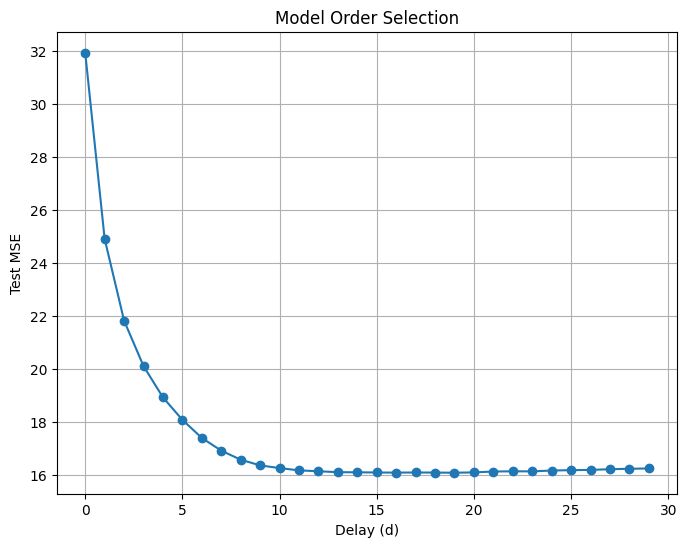

In [25]:
# TODO
best_delay = np.argmin(losses)
min_loss = losses[best_delay]
print(f"Best Delay: {best_delay} with Loss: {min_loss}")

plt.figure(figsize=(8,6))
plt.plot(range(dmax), losses, 'o-')
plt.xlabel("Delay (d)")
plt.ylabel("Test MSE")
plt.title("Model Order Selection")
plt.grid(True)
plt.show()